In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as f

import random
from itertools import count
import gc

%matplotlib inline

In [2]:
SEED = 26
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
env = gym.make('CartPole-v1')
env.seed(SEED)
env

<TimeLimit<CartPoleEnv<CartPole-v1>>>

# Cart Pole random agent
Agent takes random action untill the end of episode.
It's made to test that everything is in place

In [3]:
state, done = env.reset(), False

while not done:
    state, reward, done, info = env.step(np.random.randint(env.action_space.n))
    env.render()

env.close()

# DQN - Deep Q Network
DQN is one of the first successful attempts to apply deep neural networks in reinforcment learning.
It still looks like a Q-learning

$ Q(s_i, a_i) = Q(s_i, a_i) + \alpha * (r_i + \gamma * max_a * Q(s_{i+1}, a) - Q(s_i, a_i)) $

Where 
- $ s_i $ is current state
- $ a_i $ is taken action
- $ s_{i+1} $ is next state
- $ \alpha $ is learning rate
- $ \gamma $ is discount factor

## Main DQN components

### Replay Buffer
To store experiences

### Neural Network
Used for **target** and **online** models


In [4]:
class Net(nn.Module):

    def __init__(self, inputs, outputs, hidden=(512, 128), device='cpu'):
        super(Net, self).__init__()
        self.ac = nn.ReLU()
        self.input = nn.Linear(inputs, hidden[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden) - 1):
            self.hidden_layers.append(nn.Linear(hidden[i], hidden[i+1]))
        self.output = nn.Linear(hidden[-1], outputs)
        self.device = torch.device(device)
        self.to(self.device)
        
    def forward(self, X):
        x = self._move(X)
        x = self.ac(self.input(x))
        
        for layer in self.hidden_layers:
            x = self.ac(layer(x))
        
        return self.output(x)
    
    def _move(self, X):
        x = X
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x
    
    def load(self, experiences):
        states, actions, next_states, rewards, failied = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        failied = torch.from_numpy(failied).float().to(self.device)
        return states, actions, next_states, rewards, failied
    
net = Net(env.observation_space.shape[0], env.action_space.n)
net

Net(
  (ac): ReLU()
  (input): Linear(in_features=4, out_features=512, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

In [5]:
from collections import deque
import random

class ReplayBuffer:
    
    def __init__(self, cap=50):
        self.cap = cap
        self.buffer = deque([], maxlen=cap)
        
    def sample(self, batch_size):
        states, actions, rewards, next_states, failures = zip(*random.sample(self.buffer, batch_size))
        return np.vstack(states), np.vstack(actions), np.vstack(rewards), np.vstack(next_states), np.vstack(failures)
    
    def store(self, value):
        self.buffer.append(value)
        
    def __len__(self):
        return len(self.buffer)
    
    def __repr__(self):
        return f'ReplayBuffer(len={len(self.buffer)}, cap={self.cap})'
    
buf = ReplayBuffer()
buf

ReplayBuffer(len=0, cap=50)

In [15]:
class Agent:
    
    def __init__(self, inputs, outputs,
                 batch_size=256, buffer_size=10e3,
                 device='cpu', decay=0.9995, eps_min=0.002,
                 gamma=0.995, alpha=0.0026, lr=0.0026, arch=(256, 512, 256)):
        self.nS = inputs
        self.nA = outputs
        self.online_net = Net(inputs, outputs, device=device, hidden=arch)
        self.target_net = Net(inputs, outputs, device=device, hidden=arch)
        self.rbuffer = ReplayBuffer(cap=int(buffer_size))
        self.batch_size = batch_size
        self.step_n = 0
        self.epsilon = 1.0
        self.decay = decay
        self.eps_min = eps_min
        self.gamma = gamma
        self.lr = lr
        self.rewards = deque([], maxlen=100)
        self.last_best_reward = -np.inf
        self.mean_rewards, self.loss_hist, self.td_error_hist = [], [], []
        
    @torch.no_grad()
    def select_action(self, model, state, greedy=False):
        if np.random.random() > self.epsilon or greedy:
            qs = model(state).cpu().detach().data.numpy().squeeze()
            action = np.argmax(qs)
        else:
            action = np.random.randint(self.nA)
            
        self.epsilon = max(self.epsilon * self.decay, self.eps_min)
        return action
        
    def step(self, env, model, state, greedy=False):
        action = self.select_action(model, state, greedy)
        next_state, reward, done, info = env.step(action)
        truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        failed = float(done and not truncated)
        self.rbuffer.store((state, action, reward, next_state, failed))
        
        self.step_n += 1
        self.rewards[-1] += reward
        return next_state, done
        
    def optimize(self, experiences):
        states, actions, rewards, next_states, failures = experiences
        
        max_a = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
        target_q = rewards + (self.gamma * max_a * (1 - failures))
        
        q = self.online_net(states).gather(1, actions)
#         td_err = q - target_q
#         loss = td_err.pow(2).mul(0.5).mean()
        criterion = nn.SmoothL1Loss()
        loss = criterion(q, target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_net.parameters(), np.inf) # clip grad to inf TODO: provide real vals
        self.optimizer.step()
        
        return 0, loss.cpu().detach().mean()
        
    def train(self, env, episodes=50, update_every=25, quit_at=475.0):
        # RMSProp reached the goal in 890 episodes with seed 26
        self.optimizer = torch.optim.SGD(self.online_net.parameters(), lr=self.lr, momentum=0.9)
        eval_mean = -np.inf
        for e in range(episodes):
            state = env.reset()
            self.rewards.append(0)
            
            for c in count():
                state, done = self.step(env, self.online_net, state)
                if done:
                    gc.collect()
                    break
                    
                if len(self.rbuffer) > self.batch_size:
                    samples = self.rbuffer.sample(self.batch_size)
                    samples = self.online_net.load(samples)
                    td_err, loss = self.optimize(samples)

                # self.update() # update every step with Polyak averaging
                    
                if c % 100 == 0:
                    mean = np.mean(self.rewards)
                    print(f'\rMean reward {mean:.4f} at episode {e} epsilon {self.epsilon:.4f} buffer len {len(self.rbuffer)}; best {self.last_best_reward:.4f}; eval {eval_mean:.4f}\t', end='')
                    self.mean_rewards.append(mean)
                    self.last_best_reward = mean if mean > self.last_best_reward else self.last_best_reward
                    if len(self.rbuffer) > self.batch_size:
                        self.loss_hist.append(loss)
                        self.td_error_hist.append(td_err)
                
            if e % update_every == 0: # and len(self.mean_rewards) > 0 and self.mean_rewards[-1] >= self.last_best_reward: # Doesn't pull learning up
                self.update()
                
                eval_mean = agent.evaluate(env, episodes=5, visualize=False)
                if eval_mean >= quit_at:
                    print(f'\nReached reward {quit_at} with mean value {eval_mean} at episode {e}')
                    break
            
                
    @torch.no_grad()            
    def evaluate(self, env, episodes=10, visualize=False):
        total = []
        for e in range(episodes):
            self.rewards.append(0)
            state = env.reset()
            
            for c in count():
                state, done = self.step(env, self.target_net, state, greedy=True)
                if visualize:
                    env.render()
                if done:
                    break
                    
            episode_reward = self.rewards[-1]
            total.append(episode_reward)
            
        env.close()
        return np.mean(total)
        
    def reset(self):
        self.rewards.clear()
        self.last_best_reward = -np.inf
        
    def update(self, tau=0.1):
        # # Polyak averaging; Reached reward 500.0 over 5 evaluation episodes at episode 170
        # for target, online in zip(self.target_net.parameters(), 
        #                           self.online_net.parameters()):
        #     target.data.copy_(tau * online.data + (1.0 - tau) * target.data)
        self.target_net.load_state_dict(self.online_net.state_dict())

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'using {device} as device')
nS = env.observation_space.shape[0]
nA = env.action_space.n

using cpu as device


In [17]:
# setting seed for reproducibility
agent = Agent(nS, nA, device=device, buffer_size=10e3, batch_size=196, decay=0.9998, lr=0.0016, arch=(32, 64, 32))
agent.train(env, episodes=1000, update_every=10)

Mean reward 236.4700 at episode 370 epsilon 0.0020 buffer len 10000; best 266.2200; eval 180.6000	
Reached reward 475.0 with mean value 482.2 at episode 370


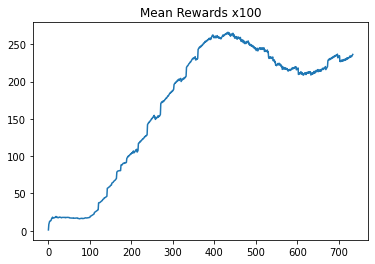

In [18]:
plt.title('Mean Rewards x100')
plt.plot(agent.mean_rewards)

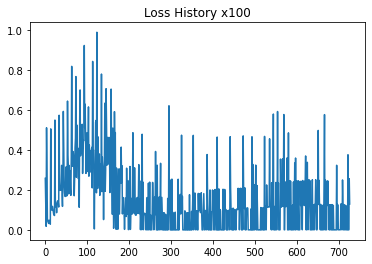

In [19]:
plt.title('Loss History x100')
plt.plot(agent.loss_hist)

In [20]:
# agent.reset()
agent.evaluate(env, visualize=True)

469.6